# Evaluación 3 – Autoencoder


En esta evaluación se implementa un modelo **autoencoder** para aprender una representación comprimida (latente) de estadísticas de partidos del Mundial de Fútbol, utilizando un conjunto de datos tabular basado en estadísticas de juego (tiros, pases, faltas, posesión, etc.).


In [7]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


## 1. Carga del conjunto de datos

Se utiliza el archivo `Fifa_world_cup_matches.csv`.

Cada fila corresponde a un partido del Mundial de Fútbol, y cada columna numérica representa una estadística del partido (goles, remates, pases, faltas, tarjetas, etc.). Además, el dataset incluye algunas columnas categóricas como nombres de equipos, fecha, hora y categoría del partido.


In [8]:
csv_path = "Fifa_world_cup_matches.csv"

df = pd.read_csv(csv_path)

print("Shape del DataFrame completo:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nTipos de datos:")
display(df.dtypes)

print("\nCantidad de valores nulos por columna:")
display(df.isna().sum())


Shape del DataFrame completo: (64, 88)

Primeras filas:


,team1,team2,possession team1,possession team2,possession in contest,number of goals team1,number of goals team2,date,hour,category,...,penalties scored team1,penalties scored team2,goal preventions team1,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,defensive pressures applied team1,defensive pressures applied team2
0,QATAR,ECUADOR,42%,50%,8%,0,2,20 NOV 2022,17 : 00,Group A,...,0,1,6,5,0,0,52,72,256,279
1,ENGLAND,IRAN,72%,19%,9%,6,2,21 NOV 2022,14 : 00,Group B,...,0,1,8,13,0,0,63,72,139,416
2,SENEGAL,NETHERLANDS,44%,45%,11%,0,2,21 NOV 2022,17 : 00,Group A,...,0,0,9,15,0,0,63,73,263,251
3,UNITED STATES,WALES,51%,39%,10%,1,1,21 NOV 2022,20 : 00,Group B,...,0,1,7,7,0,0,81,72,242,292
4,ARGENTINA,SAUDI ARABIA,64%,24%,12%,1,2,22 NOV 2022,11 : 00,Group C,...,1,0,4,14,0,0,65,80,163,361



Tipos de datos:


,0
team1,object
team2,object
possession team1,object
possession team2,object
possession in contest,object
...,...
own goals team2,int64
forced turnovers team1,int64
forced turnovers team2,int64
defensive pressures applied team1,int64



Cantidad de valores nulos por columna:


,0
team1,0
team2,0
possession team1,0
possession team2,0
possession in contest,0
...,...
own goals team2,0
forced turnovers team1,0
forced turnovers team2,0
defensive pressures applied team1,0


## 2. Selección de variables y dimensiones de entrada / latentes

Para entrenar el autoencoder se utilizarán únicamente variables numéricas:

- Todas las columnas numéricas originales.
- Las tres columnas de posesión (`possession team1`, `possession team2`, `possession in contest`), convirtiendo los porcentajes (`"42%"`) a valores numéricos (`42.0`).

Se excluyen las columnas categóricas (`team1`, `team2`, `date`, `hour`, `category`) para simplificar el modelo.

Se define:

- `input_dim`: número de variables numéricas de entrada.
- `latent_dim`: dimensión de la representación latente aprendida por el autoencoder.


In [9]:
# 1) Partimos de todas las columnas numéricas
df_num = df.select_dtypes(include=["int64", "float64"]).copy()
print("Shape solo numéricas (antes de agregar posesión):", df_num.shape)

# 2) Convertimos las columnas de posesión (que vienen como strings con '%')
possession_cols = ["possession team1", "possession team2", "possession in contest"]

df_possession = (
    df[possession_cols]
    .apply(lambda s: s.str.rstrip("%"))   # quita el símbolo %
    .astype("float32")
)

print("Shape de columnas de posesión convertidas:", df_possession.shape)

# 3) Unimos numéricas + posesión
df_features = pd.concat([df_num, df_possession], axis=1)

print("Shape final de features numéricas:", df_features.shape)
display(df_features.head())

# Matriz de entrada X
X = df_features.values.astype("float32")

# Dimensiones
input_dim = X.shape[1]   # número de columnas (features)
latent_dim = 8           # dimensión de la representación latente (puedes ajustar)

print("Dimensión de entrada (input_dim):", input_dim)
print("Dimensión latente (latent_dim):", latent_dim)


Shape solo numéricas (antes de agregar posesión): (64, 80)
Shape de columnas de posesión convertidas: (64, 3)
Shape final de features numéricas: (64, 83)


,number of goals team1,number of goals team2,total attempts team1,total attempts team2,conceded team1,conceded team2,goal inside the penalty area team1,goal inside the penalty area team2,goal outside the penalty area team1,goal outside the penalty area team2,...,goal preventions team2,own goals team1,own goals team2,forced turnovers team1,forced turnovers team2,defensive pressures applied team1,defensive pressures applied team2,possession team1,possession team2,possession in contest
0,0,2,5,6,2,0,0,2,0,0,...,5,0,0,52,72,256,279,42.0,50.0,8.0
1,6,2,13,8,2,6,6,2,0,0,...,13,0,0,63,72,139,416,72.0,19.0,9.0
2,0,2,14,9,2,0,0,2,0,0,...,15,0,0,63,73,263,251,44.0,45.0,11.0
3,1,1,6,7,1,1,1,1,0,0,...,7,0,0,81,72,242,292,51.0,39.0,10.0
4,1,2,14,3,2,1,1,2,0,0,...,14,0,0,65,80,163,361,64.0,24.0,12.0


Dimensión de entrada (input_dim): 83
Dimensión latente (latent_dim): 8


## 3. División de datos y preprocesamiento

Se realiza:

- División en conjunto de entrenamiento y prueba (`train_test_split`).
- Escalado de todas las características numéricas al rango `[0, 1]` utilizando `MinMaxScaler`.

El autoencoder aprenderá a reconstruir el vector de características a partir de sus representaciones comprimidas en el espacio latente.


In [10]:
# División train/test
x_train_raw, x_test_raw = train_test_split(
    X, test_size=0.2, random_state=42
)

print("Shape x_train_raw:", x_train_raw.shape)
print("Shape x_test_raw:", x_test_raw.shape)

# Escalado a [0, 1]
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train_raw)
x_test = scaler.transform(x_test_raw)

print("\nEjemplo de fila escalada (train[0]):")
print(x_train[0])


Shape x_train_raw: (51, 83)
Shape x_test_raw: (13, 83)

Ejemplo de fila escalada (train[0]):
[0.         0.         0.36363637 0.1875     0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.6666667  0.29411766 0.3888889  0.04166667
 0.23076925 0.33333334 0.39285716 0.36363637 0.27272728 0.
 0.36363637 0.25       0.54545456 0.21052632 0.5        0.6551724
 0.32597402 0.36609071 0.65517247 0.5090909  0.1570513  0.5182482
 0.434466   0.19508198 0.07142857 0.25925925 0.24418604 0.7118644
 0.18539324 0.35664335 0.34285715 0.39393938 0.23076925 0.32
 0.125      0.125      0.         0.         0.14814815 0.3125
 0.1        0.         0.36244017 0.23049644 0.3492823  0.22195706
 0.2857143  0.42424247 0.23529412 0.25       0.6        0.61538464
 0.33333334 0.21428573 0.23529413 0.12       0.         0.
 0.1875     0.36363637 0.         0.         0.3454545  0.12280703
 0.20281124 0.2027027  0.5833334  0.34426227 0.4545455 ]


## 4. Definición del codificador (encoder) y del decodificador (decoder)

A continuación se define la arquitectura del autoencoder en dos partes:

- **Codificador (encoder):** transforma el vector de entrada de dimensión `input_dim` en una representación comprimida de dimensión `latent_dim`.
- **Decodificador (decoder):** toma la representación latente y reconstruye un vector de la misma dimensión que la entrada original.

Las capas usan activación `ReLU` en las capas ocultas y `sigmoid` en la capa de salida, consistente con el escalado `[0, 1]` de los datos.


In [11]:
# ----- CODIFICADOR (ENCODER) -----
encoder_input = keras.Input(shape=(input_dim,), name="encoder_input")

x = layers.Dense(64, activation="relu", name="enc_dense_1")(encoder_input)
x = layers.Dense(32, activation="relu", name="enc_dense_2")(x)

# Capa latente
latent_output = layers.Dense(latent_dim, activation="linear", name="latent")(x)

encoder = keras.Model(
    inputs=encoder_input,
    outputs=latent_output,
    name="encoder"
)

encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 83)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 64)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_2 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,720 (30.16 KB)

 Trainable params: 7,720 (30.16 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# ----- DECODIFICADOR (DECODER) -----
decoder_input = keras.Input(shape=(latent_dim,), name="decoder_input")

x = layers.Dense(32, activation="relu", name="dec_dense_1")(decoder_input)
x = layers.Dense(64, activation="relu", name="dec_dense_2")(x)

decoder_output = layers.Dense(input_dim, activation="sigmoid", name="decoder_output")(x)

decoder = keras.Model(
    inputs=decoder_input,
    outputs=decoder_output,
    name="decoder"
)

decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_2 (Dense)             │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 83)             │         5,395 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,795 (30.45 KB)

 Trainable params: 7,795 (30.45 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Construcción del modelo Autoencoder

El modelo autoencoder completo conecta el codificador y el decodificador:

\[
\text{input} \xrightarrow{\text{encoder}} \text{latent} \xrightarrow{\text{decoder}} \hat{\text{input}}
\]

El objetivo de entrenamiento es minimizar el error de reconstrucción entre la entrada original y la salida reconstruida.


In [13]:
# ----- MODELO AUTOENCODER COMPLETO -----
autoencoder_input = keras.Input(shape=(input_dim,), name="ae_input")

encoded = encoder(autoencoder_input)
reconstructed = decoder(encoded)

autoencoder = keras.Model(
    inputs=autoencoder_input,
    outputs=reconstructed,
    name="autoencoder"
)

autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 83)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 8)              │         7,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 83)             │         7,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,515 (60.61 KB)

 Trainable params: 15,515 (60.61 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Modelo codificador (solo encoder)

Además del autoencoder completo, se utiliza el modelo `encoder` por separado como **modelo codificador**, el cual recibe un vector de características del partido y entrega su representación en el espacio latente de dimensión `latent_dim`.


In [14]:
print("Resumen del modelo codificador (encoder):")
encoder.summary()


Resumen del modelo codificador (encoder):


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 83)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 64)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_2 (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,720 (30.16 KB)

 Trainable params: 7,720 (30.16 KB)

 Non-trainable params: 0 (0.00 B)

## 7. Entrenamiento del autoencoder y presentación de resultados

Se compila el modelo con:

- Optimizador: `Adam`
- Función de pérdida: `MSE` (error cuadrático medio entre entrada y reconstrucción)

Se entrena usando como entrada y salida el mismo conjunto de características (`x_train` → `x_train`) y se evalúa la pérdida en el conjunto de prueba (`x_test` → `x_test`).


In [15]:
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

EPOCHS = 100
BATCH_SIZE = 8

history = autoencoder.fit(
    x_train, x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test)
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0953 - val_loss: 0.0866
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0884 - val_loss: 0.0806
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0803 - val_loss: 0.0696
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0734 - val_loss: 0.0603
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0624 - val_loss: 0.0542
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0552 - val_loss: 0.0502
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0492 - val_loss: 0.0478
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0500 - val_loss: 0.0463
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0440 - val_loss: 0.0446
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0416 - val_loss: 0.0427
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0437 - val_loss: 0.0411
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0391 - val_lo

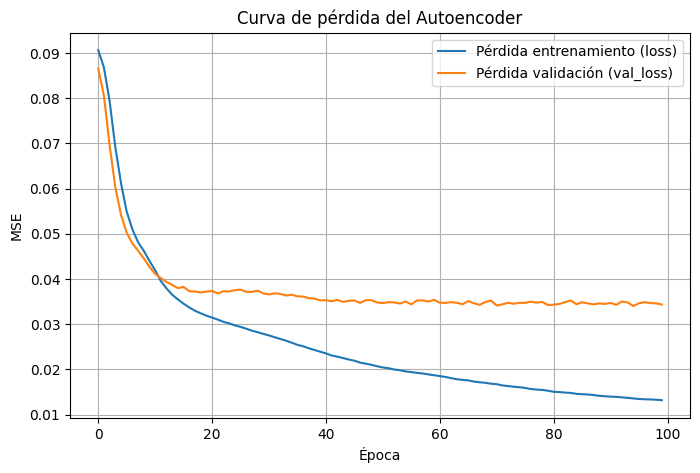

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Pérdida entrenamiento (loss)")
plt.plot(history.history["val_loss"], label="Pérdida validación (val_loss)")
plt.xlabel("Época")
plt.ylabel("MSE")
plt.title("Curva de pérdida del Autoencoder")
plt.legend()
plt.grid(True)
plt.show()


## 8. Evaluación del modelo: error de reconstrucción

A continuación se calcula el error de reconstrucción promedio y se muestran algunos ejemplos de:

- Vector de entrada original.
- Vector reconstruido por el autoencoder.

El error de reconstrucción es una medida de qué tan bien el autoencoder logra comprimir y luego reconstruir las estadísticas de cada partido.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Error de reconstrucción promedio (test): 0.034344528
Desviación estándar del error: 0.015958048


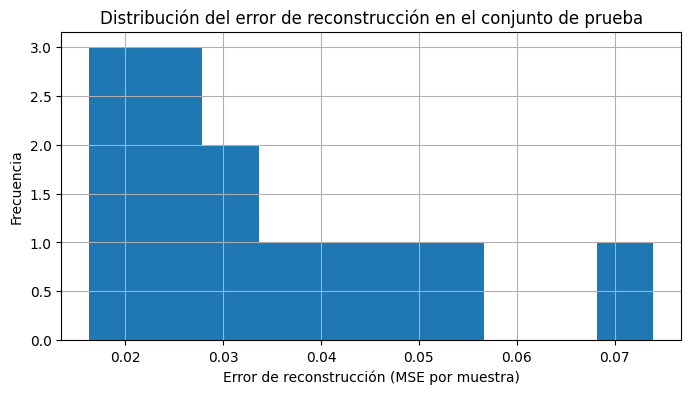

In [17]:
# Reconstrucciones sobre el conjunto de prueba
x_test_pred = autoencoder.predict(x_test)

# Error de reconstrucción por muestra (MSE por fila)
reconstruction_errors = np.mean(np.square(x_test - x_test_pred), axis=1)

print("Error de reconstrucción promedio (test):", reconstruction_errors.mean())
print("Desviación estándar del error:", reconstruction_errors.std())

plt.figure(figsize=(8, 4))
plt.hist(reconstruction_errors, bins=10)
plt.xlabel("Error de reconstrucción (MSE por muestra)")
plt.ylabel("Frecuencia")
plt.title("Distribución del error de reconstrucción en el conjunto de prueba")
plt.grid(True)
plt.show()


In [18]:
n_muestras = min(5, x_test.shape[0])

for i in range(n_muestras):
    print(f"\nMuestra {i}")
    print("Vector original (escalado):    ", np.round(x_test[i], 3))
    print("Vector reconstruido (escalado):", np.round(x_test_pred[i], 3))
    print("Error de reconstrucción MSE:", reconstruction_errors[i])



Muestra 0
Vector original (escalado):     [0.143 0.25  0.455 0.5   0.25  0.143 0.143 0.25  0.    0.    0.167 0.25
 0.4   0.308 0.444 0.471 0.278 0.375 0.538 0.467 0.429 0.455 0.455 0.538
 0.545 0.562 0.545 0.316 0.654 0.966 0.49  0.545 0.655 0.745 0.526 0.588
 0.461 0.372 0.167 0.481 0.727 1.11  0.343 0.608 0.486 0.485 0.269 0.44
 0.    0.25  0.    0.    0.37  0.688 0.3   0.    0.367 0.604 0.295 0.561
 0.571 0.909 0.353 0.75  0.267 0.462 0.667 0.357 0.588 0.44  0.    0.
 0.562 0.409 0.    0.    0.982 0.93  0.534 0.376 0.35  0.557 0.545]
Vector reconstruido (escalado): [0.055 0.062 0.222 0.383 0.053 0.05  0.037 0.059 0.054 0.053 0.04  0.03
 0.223 0.205 0.449 0.372 0.239 0.258 0.225 0.304 0.257 0.292 0.256 0.273
 0.29  0.199 0.263 0.357 0.226 0.589 0.168 0.34  0.326 0.528 0.267 0.551
 0.231 0.158 0.102 0.399 0.299 0.678 0.182 0.492 0.344 0.493 0.15  0.452
 0.154 0.055 0.008 0.    0.414 0.367 0.063 0.157 0.206 0.293 0.175 0.257
 0.204 0.541 0.137 0.309 0.281 0.428 0.243 0.373 0.345 0.376

## 9. Representación latente

Se obtienen las representaciones latentes de los partidos utilizando el modelo codificador.  
Si la dimensión latente es 2, se puede visualizar el espacio latente en un plano 2D.


In [19]:
latent_test = encoder.predict(x_test)

print("Shape de la representación latente en test:", latent_test.shape)

if latent_dim == 2:
    plt.figure(figsize=(6, 6))
    plt.scatter(latent_test[:, 0], latent_test[:, 1])
    plt.xlabel("Latent dim 1")
    plt.ylabel("Latent dim 2")
    plt.title("Representación latente de los partidos (test)")
    plt.grid(True)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Shape de la representación latente en test: (13, 8)


## 10. Conclusiones

El autoencoder se entrenó utilizando estadísticas numéricas de partidos del Mundial (goles, remates, pases, faltas, posesión, etc.) y una representación latente de dimensión `latent_dim = 8`.

En el conjunto de prueba se obtuvo:

- **Error de reconstrucción promedio (test):** 0.0343  
- **Desviación estándar del error:** 0.0160  

Estos resultados indican que, en promedio, el modelo es capaz de reconstruir razonablemente bien los vectores de características originales a partir de su representación comprimida en el espacio latente. Un error de reconstrucción bajo sugiere que el autoencoder logró capturar patrones relevantes de las estadísticas de los partidos en una dimensión menor.

A partir de este modelo, sería posible explorar aplicaciones adicionales, como:

- Visualización del espacio latente para analizar similitudes entre partidos.
- Detección de partidos atípicos (outliers) identificando aquellos con un error de reconstrucción significativamente mayor que el promedio.
- Uso de las representaciones latentes como entrada para otros modelos supervisados (por ejemplo, para clasificar tipos de partidos o predecir ciertos resultados).
